ctrl-b: scratchpad
alt-f: codefolding

# Data Manipulation

## Load Data

In [1]:
import sys
import numpy as np
import numpy.lib.recfunctions as nprf
from sklearn import linear_model
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['figure.facecolor'] = (1,1,1,1)

import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
from matt_tools import *

In [3]:
wdir = '/share/scratch1/mho1/halo_sdm/'
out_dat = 'MDPL2_large_z=0.117'

In [4]:
dat_orig = np.load(wdir+"data/MDPL2_large_z=0.117.npy")

In [5]:
keep = ['Mtot', 'rotation', 'fold', 'Ngal', 'vlos', 'Rproj',
        'name', 'intest', 'intrain', 'redshift','sigmav'
       ]
print sys.getsizeof(dat_orig)/10.**9, ' GB'

temp = nprf.drop_fields(dat_orig, 
                            [i for i in dat_orig.dtype.names if i not in keep])

print sys.getsizeof(temp)/10.**9, ' GB'

del(dat_orig)

dat_orig = temp

7.046732052  GB
0.86529754  GB


In [6]:
dat_hmf = np.loadtxt(wdir+"data/dn_by_dm_md_om=0.307_s8=0.823_z=0.117.txt")

x_hmf = zip(*dat_hmf)
y_hmf = np.log10(x_hmf[1])
x_hmf = np.log10(x_hmf[0])

In [7]:
dat = dat_orig
# len(dat)
# dat = dat_filt

In [8]:
temp = add_vsig(dat)
del(dat)
dat = add_rsig(temp)
del(temp)
# dat_train = dat[dat['intrain']==True]
# dat_test = dat[dat['intest']==True]

## Characterize dataset

(-8, -3)

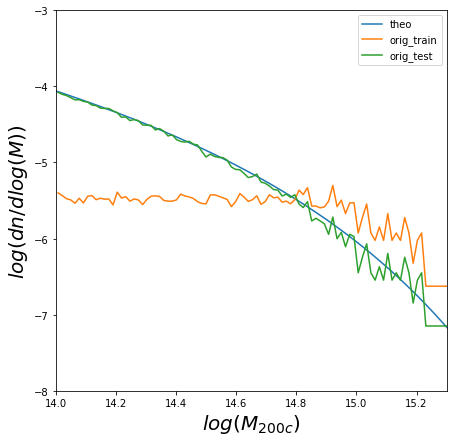

In [9]:
f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

plt.plot(x_hmf,y_hmf, label='theo')

histplot(np.log10(dat['Mtot'][dat['intrain']==True]), n=100, label='orig_train')
histplot(np.log10(dat['Mtot'][dat['intest']==True]), n=100, label='orig_test')

plt.xlabel(r'$log(M_{200c}$)', fontsize=20)
plt.ylabel(r'$log(dn/dlog(M))$', fontsize=20)
plt.legend()

ax.set_xlim(14,15.3)
ax.set_ylim(-8,-3)

# savefig(f,out_dat + '_massprof', wdir, xlabel=r'$log(M_{200c})$', ylabel=r'$log(dn/dlog(M))$')

0.409552335739
-3.1650519042


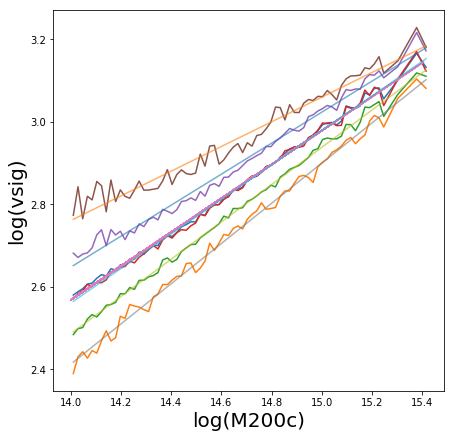

In [14]:
f = plt.figure(figsize = (7,7))

x = np.log10(dat['Mtot'][dat['intrain']==True])
y = np.log10(dat['vsig'][dat['intrain']==True])

xx, ymean, \
y_percent, yerr = binnedplot(x, 
                           y, 
                           n=75,
                           percentiles = [2,15,50,85,98]
                          )

regr0 = linear_model.LinearRegression(fit_intercept=True)
regr0.fit(x.reshape((len(x),1)),y.reshape((len(y),1)))

plt.plot(x,x*regr0.coef_[0] + regr0.intercept_[0], label='fit')


xx = np.array(xx).reshape(-1,1)
regr_percent = []
for i in range(len(y_percent)):
    regr_percent.append(linear_model.LinearRegression(fit_intercept=True))
    regr_percent[i].fit(xx,y_percent[i],1)

    plt.plot(xx,xx*regr_percent[i].coef_[0] + regr_percent[i].intercept_,
             alpha=0.6
            )

    
plt.xlabel('log(M200c)', fontsize=20)
plt.ylabel('log(vsig)', fontsize=20)

# plt.legend()

print regr0.coef_[0][0]
print regr0.intercept_[0]

# savefig(f,out_dat + '_massvsig', wdir, xlabel=r'$log(M_{200c})$', ylabel=r'$log(\sigma_v)$')

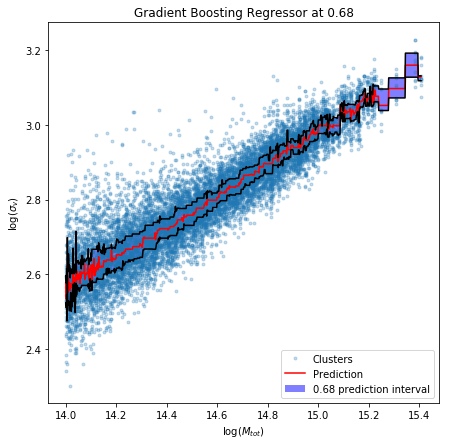

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

alpha = 0.68
clf = GradientBoostingRegressor(loss='quantile', alpha = alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=0.1, min_samples_leaf=9,
                                min_samples_split=9
                               )
x = np.log10(dat['Mtot'][dat['intrain']==True]).reshape(-1,1)
y = np.log10(dat['vsig'][dat['intrain']==True])

xx = np.atleast_2d(np.linspace(x.min(), x.max(),1000)).T

clf.fit(x,y)

y_upper = clf.predict(xx)

clf.set_params(alpha = 1-alpha)
clf.fit(x,y)

y_lower = clf.predict(xx)

clf.set_params(loss='huber',alpha=0.5)
clf.fit(x,y)

y_pred = clf.predict(xx)

plt.figure(figsize=(7,7))
plt.plot(x,y,'.',alpha=0.25, label=u'Clusters')
plt.plot(xx,y_pred,'r-', label=u'Prediction')
plt.plot(xx,y_lower,'k-')
plt.plot(xx,y_upper,'k-')
plt.fill()
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', label=str(alpha) + ' prediction interval')
plt.xlabel('$\log(M_{tot})$')
plt.ylabel('$\log(\sigma_v)$')
plt.title('Gradient Boosting Regressor at '+str(alpha))
plt.legend()


178
926
2019
2451
2447
1921
821


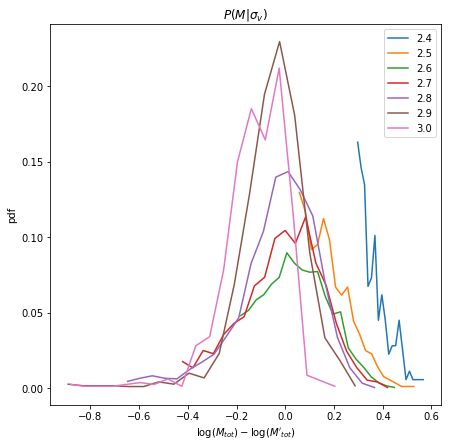

In [13]:

m = 2.4
m_int = 0.1

plt.figure(figsize=(7,7))

while m < 3.05:

    slice_ = ((y>=m) & (y <= (m+m_int))).flatten()

    x_slice = x[slice_]
    y_slice = y[slice_]
    print len(x_slice)
    
    ctr = 1./regr0.coef_[0]*((m+m_int/2)- regr0.intercept_[0])
    
    t = histplot(x_slice - ctr, n=20, label = str(m), log=False, norm=True)
    
    m+=m_int
plt.xlabel("$\log(M_{tot}) - \log(M'_{tot})$")
plt.ylabel("pdf")
plt.legend()
plt.title('$P(M|\sigma_v)$')

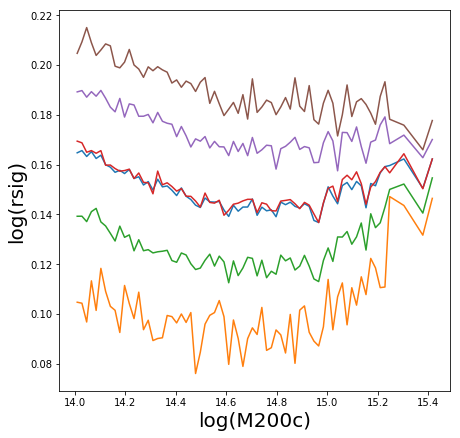

In [11]:

f = plt.figure(figsize = (7,7))

x = np.log10(dat['Mtot'][dat['intrain']==True])
y = np.log10(dat['rsig'][dat['intrain']==True])

p = binnedplot(x, 
           y, 
           n=75,
           percentiles = [2,15,50,85,98]
          )

plt.xlabel('log(M200c)', fontsize=20)
plt.ylabel('log(rsig)', fontsize=20)

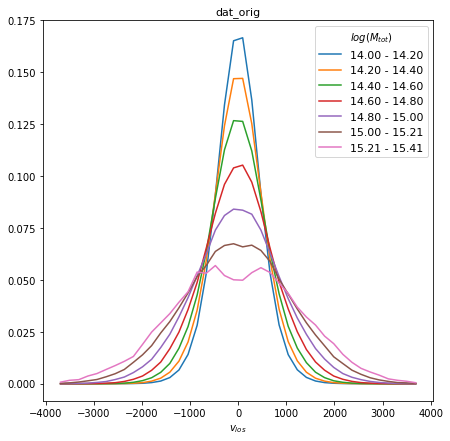

In [12]:
f = plt.figure(figsize=(7,7))
pdfs(dat_orig, mbins=7, vbins=40, norm=False)
plt.title('dat_orig', fontsize=11)
plt.xlabel(r'$v_{los}$')
plt.legend(fontsize=11,title=r'$log(M_{tot})$')
# savefig(f,out_dat + '_vprof', xlabel=r'$v_{los}$')

In [13]:
rcut = dat['Rproj'].max()
vcut = dat['vlos'].max()

print 'aperature: ' + str(dat['Rproj'].max())

print 'vcut: '+ str(dat['vlos'].max())


aperature: 2.3
vcut: 3780.7


## Buffer both sides

In [38]:
dat_both = dat_orig[(dat_orig['Mtot'] < 10**15) & (dat_orig['rotation']<=10)]
print 'rotation<=10 and mtot<10**15: ', len(dat_both)

selection = ((dat_both['Mtot'] > 10**14) & (dat_both['Mtot'] < 10**15))
selection = (selection & (dat_both['intrain']==True)) #& (selection['intest']==False)]
selection = np.argwhere(selection).flatten()

selection = np.random.choice(selection, len(selection)*2/3, replace=False)
print 'selection: ', len(selection)

temp = dat_both[selection]
temp2 = dat_both[[i for i in range(len(dat_both)) if i not in selection]]
del(dat_both)

dat_both = temp2
selection = temp
del(temp2)
del(temp)

print 'len(dat_both): ', len(dat_both)

rotation<=10 and mtot<10**15:  70847
selection:  6614
len(dat_both):  64233


regr.coef:  0.387452453375
regr.intercept:  -2.84724485089


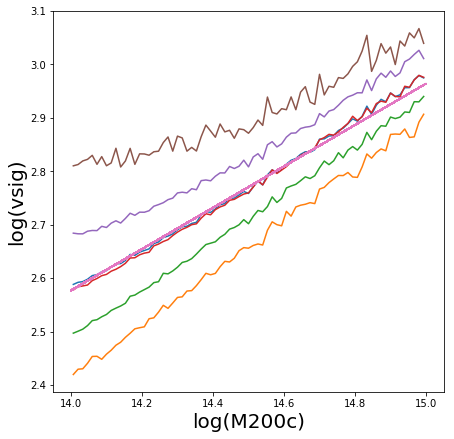

In [39]:
dat_regr = dat[(dat['Mtot']>10**14) & (dat['Mtot']<10**15)]
m = np.log10(dat_regr['Mtot'])
vsig = np.log10( dat_regr['vsig'] )

f = plt.figure(figsize=(7,7))

binnedplot(m, 
           vsig, 
           n=75,
           percentiles = [2,15,50,85,98]
          )

regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(m.reshape((len(m),1)),vsig.reshape((len(vsig),1)))

plt.plot(m,m*regr.coef_[0] + regr.intercept_[0], label='fit')

plt.xlabel('log(M200c)', fontsize=20)
plt.ylabel('log(vsig)', fontsize=20)

# plt.legend()

print 'regr.coef: ', regr.coef_[0][0]
print 'regr.intercept: ', regr.intercept_[0]

# savefig(f,out_dat + '_massvsig_prebuffer', xlabel=r'$log(M_{200c})$', ylabel=r'$log(\sigma_v)$')

In [40]:
for i in range(len(selection)):
    if np.random.rand() > 0.5:
        newmass  = 10**(15+np.random.rand())
    else:
        newmass = 10**(13+np.random.rand())
        
    selection[i]['vlos'] = selection[i]['vlos']*(newmass/selection[i]['Mtot'])**regr.coef_[0][0]
    
    toobig = np.abs(selection[i]['vlos']) >= vcut
    selection[i]['vlos'] = np.append(selection[i]['vlos'][~toobig], [0]*np.sum(toobig))
    selection[i]['Ngal']-=np.sum(toobig)
    
    selection[i]['Mtot'] = newmass
#     selection['intest'] = False


# sel:  363
# orig:  450
 
# sel:  3228
# orig:  0


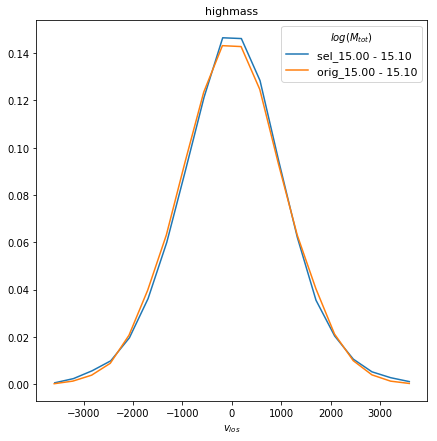

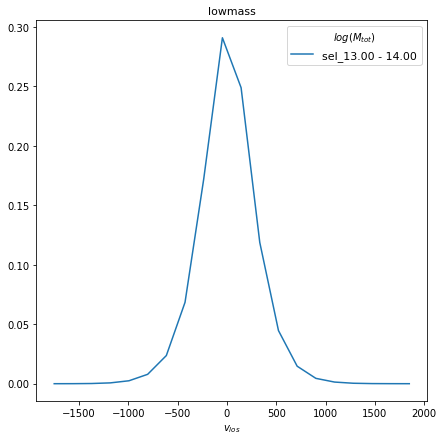

In [41]:
b = (10**15,10**15.1)

f = plt.figure(figsize=(7,7))

print '# sel: ', np.sum((selection['Mtot']> b[0]) * (selection['Mtot']< b[1] ))
print '# orig: ', np.sum((dat_orig['Mtot']> b[0]) * (dat_orig['Mtot']< b[1] ))

pdfs(selection[(selection['Mtot']> b[0]) * (selection['Mtot']< b[1] )], mbins=1, norm=False, label = 'sel')
pdfs(dat_orig[(dat_orig['Mtot']> b[0]) * (dat_orig['Mtot']< b[1] )], mbins=1, norm=False, label = 'orig')

plt.title('highmass', fontsize=11)
plt.xlabel(r'$v_{los}$')
plt.legend(fontsize=11,title=r'$log(M_{tot})$')

print ' '

b = (10**13,10**14)
f = plt.figure(figsize=(7,7))

print '# sel: ', np.sum((selection['Mtot']> b[0]) * (selection['Mtot']< b[1] ))
print '# orig: ', np.sum((dat_orig['Mtot']> b[0]) * (dat_orig['Mtot']< b[1] ))

pdfs(selection[(selection['Mtot']> b[0]) * (selection['Mtot']< b[1] )], mbins=1, norm=False, label = 'sel')
pdfs(dat_orig[(dat_orig['Mtot']> b[0]) * (dat_orig['Mtot']< b[1] )], mbins=1, norm=False, label = 'orig')

plt.title('lowmass', fontsize=11)
plt.xlabel(r'$v_{los}$')
plt.legend(fontsize=11,title=r'$log(M_{tot})$')


In [42]:
temp = np.append(dat_both, selection)
dat_both = temp
del(temp)
del(selection)

print 'len(dat_both): ', len(dat_both)

len(dat_both):  70847


In [19]:
# np.save(wdir + "data/"+out_dat+"_buffer.npy", dat_both)

## Buffer Both All

In [27]:
dat_temp = dat_orig[(dat_orig['Mtot'] < 10**15) & (dat_orig['rotation']<=10)]
print 'rotation<=10 and mtot<10**15: ', len(dat_temp)

selection = ((dat_temp['Mtot'] > 10**14) & (dat_temp['Mtot'] < 10**15))
selection = (selection & (dat_temp['intrain']==True)) #& (selection['intest']==False)]
selection = np.argwhere(selection).flatten()

selection = np.random.choice(selection, len(selection)*3/3, replace=False)
print 'selection: ', len(selection)

temp = dat_temp[selection]
temp2 = dat_temp[[i for i in range(len(dat_temp)) if i not in selection]]
del(dat_temp)

dat_temp = temp2
selection = temp
del(temp2)
del(temp)

print 'len(dat_temp): ', len(dat_temp)

rotation<=10 and mtot<10**15:  70847
selection:  9921
len(dat_temp):  60926


regr.coef:  0.387452453375
regr.intercept:  -2.84724485089


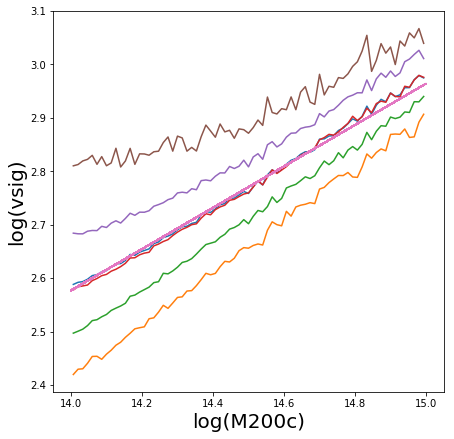

In [28]:
dat_regr = dat[(dat['Mtot']>10**14) & (dat['Mtot']<10**15)]
m = np.log10(dat_regr['Mtot'])
vsig = np.log10( dat_regr['vsig'] )

f = plt.figure(figsize=(7,7))

binnedplot(m, 
           vsig, 
           n=75,
           percentiles = [2,15,50,85,98]
          )

regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(m.reshape((len(m),1)),vsig.reshape((len(vsig),1)))

plt.plot(m,m*regr.coef_[0] + regr.intercept_[0], label='fit')

plt.xlabel('log(M200c)', fontsize=20)
plt.ylabel('log(vsig)', fontsize=20)

# plt.legend()

print 'regr.coef: ', regr.coef_[0][0]
print 'regr.intercept: ', regr.intercept_[0]

# savefig(f,out_dat + '_massvsig_prebuffer', xlabel=r'$log(M_{200c})$', ylabel=r'$log(\sigma_v)$')

In [29]:
for i in range(len(selection)):
    newmass = 10**(13+3*np.random.rand())
        
    selection[i]['vlos'] = selection[i]['vlos']*(newmass/selection[i]['Mtot'])**regr.coef_[0][0]
    
    toobig = np.abs(selection[i]['vlos']) >= vcut
    selection[i]['vlos'] = np.append(selection[i]['vlos'][~toobig], [0]*np.sum(toobig))
    selection[i]['Ngal']-=np.sum(toobig)
    
    selection[i]['Mtot'] = newmass
#     selection['intest'] = False


In [30]:
temp = np.append(dat_temp, selection)
dat_both_all = temp
del(temp)
del(dat_temp)
del(selection)

print 'len(dat_both_all): ', len(dat_both_all)

len(dat_both_all):  70847


In [50]:
np.save(wdir + "data/"+out_dat+"_bufferall.npy", dat_both_all)

## Buffer Both R

In [20]:
dat_both_r = dat_orig[(dat_orig['Mtot'] < 10**15) & (dat_orig['rotation']<=10)]
print 'rotation<=10 and mtot<10**15: ', len(dat_both_r)

selection = ((dat_both_r['Mtot'] > 10**14) & (dat_both_r['Mtot'] < 10**15))
selection = (selection & (dat_both_r['intrain']==True)) #& (selection['intest']==False)]
selection = np.argwhere(selection).flatten()

selection = np.random.choice(selection, len(selection)*2/3, replace=False)
print 'selection: ', len(selection)

temp = dat_both_r[selection]
temp2 = dat_both_r[[i for i in range(len(dat_both_r)) if i not in selection]]
del(dat_both_r)

dat_both_r = temp2
selection = temp
del(temp2)
del(temp)

print 'len(dat_both_r): ', len(dat_both_r)

rotation<=10 and mtot<10**15:  70847
selection:  6614
len(dat_both_r):  64233


regr_r.coef:  -0.0320879109204
regr_r.intercept:  0.613153370682


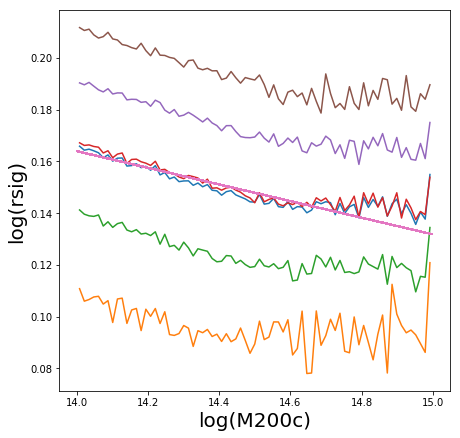

In [21]:
# dat_regr = dat[(dat['Mtot']>10**14) & (dat['Mtot']<10**15)]
m = np.log10(dat_regr['Mtot'])
rsig = np.log10(dat_regr['rsig'])

f = plt.figure(figsize=(7,7))

binnedplot(m, 
           rsig, 
           n=75,
           percentiles = [2,15,50,85,98]
          )

regr_r = linear_model.LinearRegression(fit_intercept=True)
regr_r.fit(m.reshape((len(m),1)),rsig.reshape((len(rsig),1)))

plt.plot(m,m*regr_r.coef_[0] + regr_r.intercept_[0], label='fit')

plt.xlabel('log(M200c)', fontsize=20)
plt.ylabel('log(rsig)', fontsize=20)

# plt.legend()

print 'regr_r.coef: ', regr_r.coef_[0][0]
print 'regr_r.intercept: ', regr_r.intercept_[0]

# savefig(f,out_dat + '_prebuffer', xlabel=r'$log(M_{200c})$', ylabel=r'$log(\sigma_v)$')

In [22]:
for i in range(len(selection)):
    if np.random.rand() > 0.5:
        newmass  = 10**(15+np.random.rand())
    else:
        newmass = 10**(13+np.random.rand())
        
    selection['vlos'][i] = selection['vlos'][i]*(newmass/selection['Mtot'][i])**regr.coef_[0][0]
    selection['Rproj'][i] = selection['Rproj'][i]*(newmass/selection['Mtot'][i])**regr_r.coef_[0][0]
    
    toobig = (np.abs(selection['vlos'][i]) >= vcut) | (selection['Rproj'][i] >= rcut)
    selection['vlos'][i] = np.append(selection['vlos'][i][~toobig], [0]*np.sum(toobig))
    selection['Rproj'][i] = np.append(selection['Rproj'][i][~toobig], [0]*np.sum(toobig))
    
    selection['Ngal'][i]-=np.sum(toobig)
    
    selection['Mtot'][i] = newmass
#     selection['intest'] = False
    
temp = np.append(dat_both_r, selection)
dat_both_r = temp
del(temp)
del(selection)

print 'len(dat_both_r): ', len(dat_both_r)

len(dat_both_r):  70847


In [23]:
# np.save(wdir + "data/" + out_dat + "_z=0.117_buffer_bothr.npy", dat_both_r)

## Buffer Low


In [24]:
dat_low = dat_orig[(dat_orig['Mtot'] < 10**15) & (dat_orig['rotation']<=10)]
print 'rotation<=10 and mtot<10**15: ', len(dat_low)

selection = ((dat_low['Mtot'] > 10**14) & (dat_low['Mtot'] < 10**15))
selection = (selection & (dat_low['intrain']==True)) #& (selection['intest']==False)]
selection = np.argwhere(selection).flatten()

selection = np.random.choice(selection, len(selection)*1/2, replace=False)
print 'len(selection): ', len(selection)

temp = dat_low[selection]
temp2 = dat_low[[i for i in range(len(dat_low)) if i not in selection]]
del(dat_low)

dat_low = temp2
selection = temp
del(temp2)
del(temp)

print 'len(dat_low): ', len(dat_low)
print 'len(selection): ', len(selection)

rotation<=10 and mtot<10**15:  70847
len(selection):  4960
len(dat_low):  65887
len(selection):  4960


In [25]:
for i in range(len(selection)):
    newmass = 10**(13+np.random.rand())
        
    selection['vlos'][i] = selection['vlos'][i]*(newmass/selection['Mtot'][i])**regr.coef_[0][0]
    
    toobig = np.abs(selection['vlos'][i]) >= vcut
    selection['vlos'][i] = np.append(selection['vlos'][i][~toobig], [0]*np.sum(toobig))
    selection['Ngal'][i]-=np.sum(toobig)
    
    selection['Mtot'][i] = newmass
#     selection['intest'] = False
    
temp = np.append(dat_low, selection)
dat_low = temp
del(temp)
del(selection)

print 'len(dat_low): ', len(dat_low)

len(dat_low):  70847


In [26]:
# np.save(wdir + "data/" + out_dat + "_bufferlow.npy", dat_low)

## Data Profiles

In [45]:
dat = dat
# dat_train = dat_train
# dat_test = dat_test

temp = add_vsig(dat_both)
del(dat_both)
dat_both = temp
del(temp)
# dat_both_train = dat_both[dat_both['intrain']==True]
# dat_both_test = dat_both[dat_both['intest']==True]

# temp = add_vsig(dat_low)
# del(dat_low)
# dat_low = temp
# del(temp)
# dat_low_train = dat_low[dat_low['intrain']==True]
# dat_low_test = dat_low[dat_low['intest']==True]

In [33]:
temp = add_vsig(dat_both_all)
del(dat_both_all)
dat_both_all = temp
del(temp)

/home/mho1/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 70847 but corresponding boolean dimension is 71797
/home/mho1/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 70847 but corresponding boolean dimension is 71797


(-8, -3)

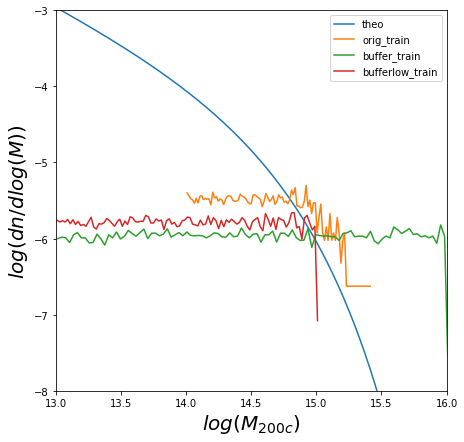

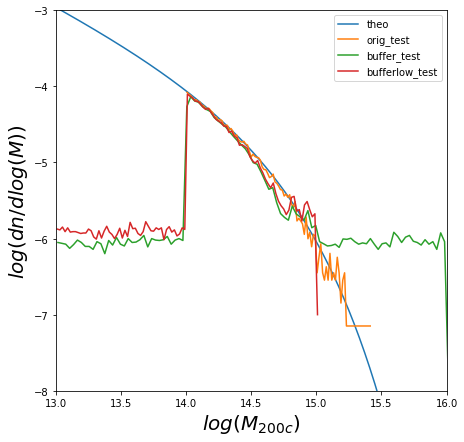

In [28]:
f = plt.figure(figsize = (7,7))
ax = f.add_subplot(111)

plt.plot(x_hmf,y_hmf, label='theo')
histplot(np.log10(dat['Mtot'][dat['intrain']==True]), n=100, label='orig_train')
histplot(np.log10(dat_both['Mtot'][dat_both['intrain']==True]), n=100, label='buffer_train')
histplot(np.log10(dat_low['Mtot'][dat_low['intrain']==True]), n=100, label='bufferlow_train')


plt.xlabel(r'$log(M_{200c}$)', fontsize=20)
plt.ylabel(r'$log(dn/dlog(M))$', fontsize=20)
plt.legend()
# plt.legend(fontsize=7)

ax.set_xlim(13,16)
ax.set_ylim(-8,-3)

# savefig(f,out_dat + '_massprof_buffer_train', xlabel=r'$log(M_{200c})$', ylabel=r'$log(dn/dlog(M))$')


f = plt.figure(figsize = (7,7))
ax = f.add_subplot(111)

plt.plot(x_hmf,y_hmf, label='theo')
histplot(np.log10(dat['Mtot'][dat['intest']==True]), n=100, label='orig_test')
histplot(np.log10(dat_both['Mtot'][dat['intest']==True]), n=100, label='buffer_test')
histplot(np.log10(dat_low['Mtot'][dat['intest']==True]), n=100, label='bufferlow_test')

plt.xlabel(r'$log(M_{200c}$)', fontsize=20)
plt.ylabel(r'$log(dn/dlog(M))$', fontsize=20)
plt.legend()
# plt.legend(fontsize=7)

ax.set_xlim(13,16)
ax.set_ylim(-8,-3)

# savefig(f,out_dat + '_massprof_buffer_test', xlabel=r'$log(M_{200c})$', ylabel=r'$log(dn/dlog(M))$')


In [46]:
# massList_train = massList_train3
# vsigList_train = vsigList_train3
# massList_test = massList_test3
# vsigList_test = vsigList_test3
dat_temp = dat_both

dat_temp = dat_temp[dat_temp['intrain']==1]

0.365115076303
-2.5347502495


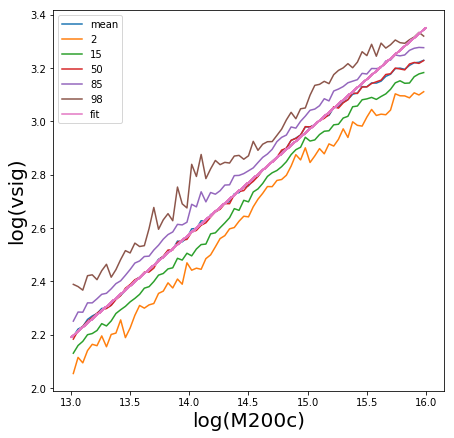

In [47]:
f = plt.figure(figsize = (7,7))

x = np.log10(dat_temp['Mtot'])
y = np.log10(dat_temp['vsig'])

binnedplot(x, 
           y, 
           n=75,
           percentiles = [2,15,50,85,98]
          )

regr1 = linear_model.LinearRegression(fit_intercept=True)
regr1.fit(x.reshape((len(x),1)),y.reshape((len(y),1)))

plt.plot(x,x*regr.coef_[0] + regr.intercept_[0], label='fit')

plt.xlabel('log(M200c)', fontsize=20)
plt.ylabel('log(vsig)', fontsize=20)

plt.legend()

print regr1.coef_[0][0]
print regr1.intercept_[0]

# savefig(f,out_dat + '_massvsig_bufferlow', xlabel=r'$log(M_{200c})$', ylabel=r'$log(\sigma_v)$')

(-8, -3)

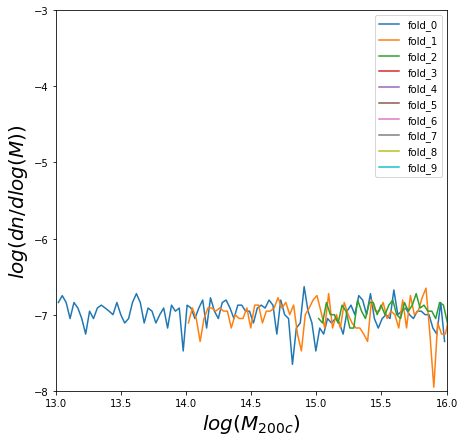

In [31]:
f = plt.figure(figsize = (7,7))
ax = f.add_subplot(111)

foldmassdist(dat_temp)

plt.xlabel(r'$log(M_{200c}$)', fontsize=20)
plt.ylabel(r'$log(dn/dlog(M))$', fontsize=20)
plt.legend()
# plt.legend(fontsize=7)

ax.set_xlim(13,16)
ax.set_ylim(-8,-3)

NameError: name 'dat_low_ref' is not defined

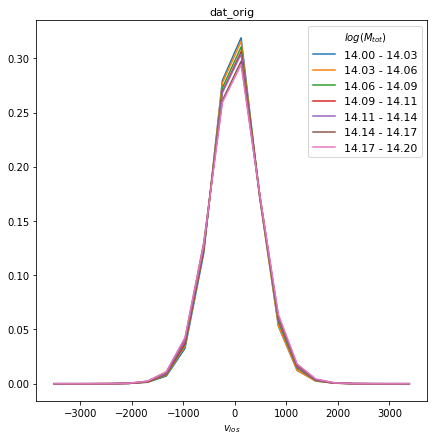

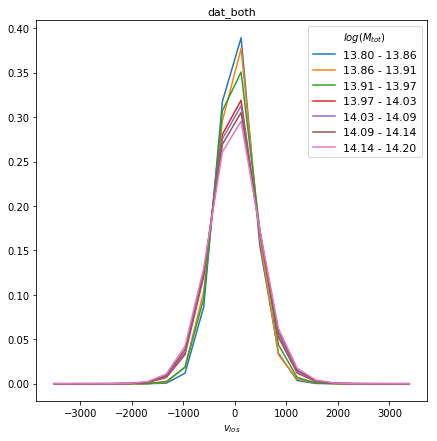

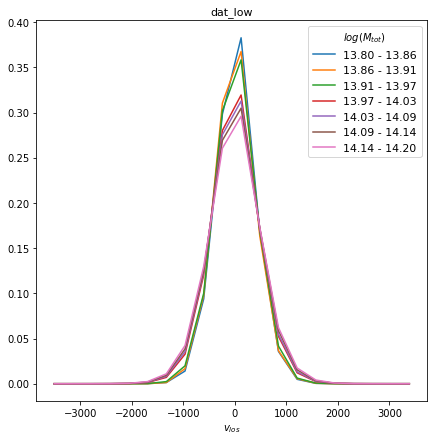

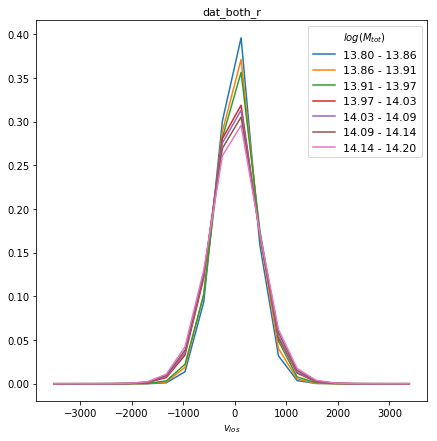

In [32]:
b = [10**13.8, 10**14.2]

f = plt.figure(figsize=(7,7))
pdfs(dat[(dat['Mtot']> b[0] ) * (dat['Mtot']< b[1] ) ], mbins=7, norm=False)
plt.title('dat_orig', fontsize=11)
plt.xlabel(r'$v_{los}$')
plt.legend(fontsize=11,title=r'$log(M_{tot})$')
# savefig(f,out_dat + '_vprof', xlabel=r'$v_{los}$')

f = plt.figure(figsize=(7,7))
pdfs(dat_both[(dat_both['Mtot']> b[0]) * (dat_both['Mtot']< b[1] )], mbins=7, norm=False)
plt.title('dat_both', fontsize=11)
plt.xlabel(r'$v_{los}$')
plt.legend(fontsize=11,title=r'$log(M_{tot})$')
# savefig(f,out_dat + '_vprof_buffer', xlabel=r'$v_{los}$')

f = plt.figure(figsize=(7,7))
# pdfs(dat_low[dat_low['intrain']==1], mbins=5, norm=False)
pdfs(dat_low[(dat_low['Mtot']> b[0]) * (dat_low['Mtot']< b[1] )], mbins=7, norm=False)
plt.title('dat_low', fontsize=11)
plt.xlabel(r'$v_{los}$')
plt.legend(fontsize=11,title=r'$log(M_{tot})$')
# savefig(f,out_dat + '_vprof_bufferlow', xlabel=r'$v_{los}$')

f = plt.figure(figsize=(7,7))
# pdfs(dat_both_r[dat_both_r['intrain']==1], mbins=5, norm=False)
pdfs(dat_both_r[(dat_both_r['Mtot']> b[0]) * (dat_both_r['Mtot']< b[1] )], mbins=7, norm=False)
plt.title('dat_both_r', fontsize=11)
plt.xlabel(r'$v_{los}$')
plt.legend(fontsize=11,title=r'$log(M_{tot})$')
# savefig(f,out_dat + '_vprof_bufferR', xlabel=r'$v_{los}$')

f = plt.figure(figsize=(7,7))
# pdfs(dat_both_r[dat_both_r['intrain']==1], mbins=5, norm=False)
pdfs(dat_low_ref[(dat_low_ref['Mtot']> b[0]) * (dat_low_ref['Mtot']< b[1] )], mbins=7, norm=False)
plt.title('dat_low_ref', fontsize=11)
plt.xlabel(r'$v_{los}$')
plt.legend(fontsize=11,title=r'$log(M_{tot})$')
# savefig(f,out_dat + '_vprof_bufferR', xlabel=r'$v_{los}$')
